# Time Series Forecasting for Future Sales
---
**Submitted by: Sheetal Bongale | March 2021**

Steps -
1. Data Wrangling and Exploratory Data Analysis
2. Feature Engineering and Selection
3. **Modeling and forecasting**
4. **Model evaluation and validation**
5. **Sales quantity forecast results and visualization**
6. Final results and analysis report

In [131]:
# import libraries
import pandas as pd
import numpy as np
import math
from pandas import DataFrame
from pandas import Series
from pandas import concat
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.api as smt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt

pio.renderers
pio.renderers.default='notebook+jupyterlab'
plotly.offline.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

In [33]:
df = pd.read_csv("../data/top_selling_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2289 entries, 0 to 2288
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    2289 non-null   int64  
 1   StockCode    2289 non-null   object 
 2   Description  2289 non-null   object 
 3   Quantity     2289 non-null   int64  
 4   InvoiceDate  2289 non-null   object 
 5   UnitPrice    2289 non-null   float64
 6   CustomerID   2289 non-null   float64
 7   Country      2289 non-null   object 
 8   Year         2289 non-null   int64  
 9   Quarter      2289 non-null   int64  
 10  Month        2289 non-null   int64  
 11  Week         2289 non-null   int64  
 12  Day          2289 non-null   int64  
 13  Weekday      2289 non-null   int64  
 14  Date         2289 non-null   object 
 15  Total_Sales  2289 non-null   float64
dtypes: float64(3), int64(8), object(5)
memory usage: 286.2+ KB


In [34]:
df['Date'] = pd.to_datetime(df['Date'])

## EDA

In [35]:
# Duration of dataset
def sales_duration(data):
    data.Date = pd.to_datetime(data.Date)
    number_of_days = data.Date.max() - data.Date.min()
    number_of_years = number_of_days.days / 365
    print(number_of_days.days, 'days')
    print(number_of_years, 'years')
    
sales_duration(df)

373 days
1.021917808219178 years


In [36]:
df_sales = df.groupby(['Date'])['Quantity'].sum().reset_index()
df['Date'] = pd.to_datetime(df['Date'])

In [37]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(12,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    second = data.groupby(data.Date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.Date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(365)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()


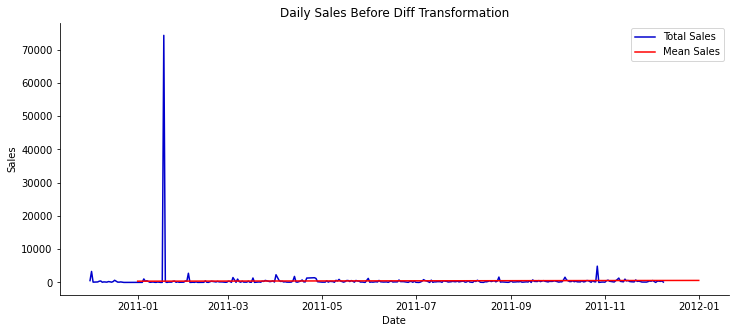

In [38]:
time_plot(df_sales, 'Date', 'Quantity', 'Daily Sales Before Diff Transformation')

## Item 1: MEDIUM CERAMIC TOP STORAGE JAR

In [39]:
df1 = df.loc[df['Description']=='MEDIUM CERAMIC TOP STORAGE JAR']

In [40]:
df1_sales = df1.groupby(['Date'])['Quantity'].sum().reset_index()
df1_sales['Date'] = pd.to_datetime(df1_sales['Date'])

In [41]:
output = adfuller(df1_sales.Quantity)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -1528.78 and p-value: 0.00000


In [42]:
d=1
series_date = df1_sales.Quantity.diff(d)
series_date = series_date.dropna()
output = adfuller(series_date)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -7.27 and p-value: 0.00000


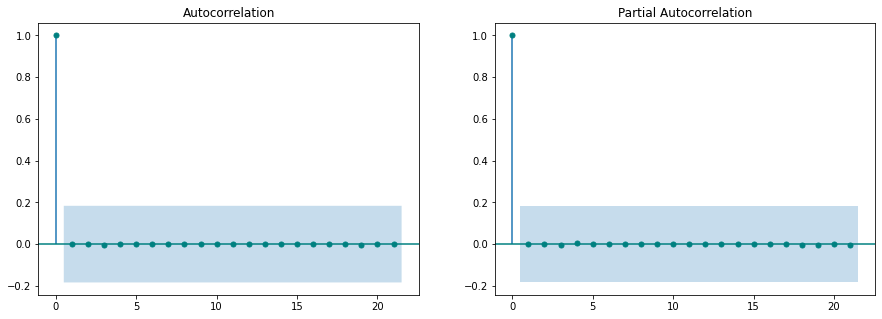

In [43]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(series_date, ax=ax[0], color = 'teal')
plot_pacf(series_date, ax=ax[1], color = 'teal')
plt.show()

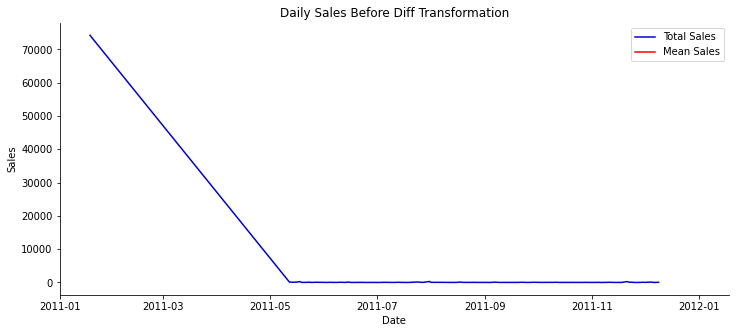

In [44]:
time_plot(df1_sales, 'Date', 'Quantity', 'Daily Sales Before Diff Transformation')

In [45]:
fig = go.Figure(data=[go.Scatter(x=df1_sales.Date, y=df1_sales.Quantity, line_color='darkturquoise')])
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Total Quantity", 
                  title='Daily Sales by Quantity',
                  height=400,
                 template='ggplot2')
fig.show()

### 2.1 ARIMA

In [46]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
model=ARIMA(df1_sales['Quantity'],order=(1,1,0))
model_fit=model.fit()

In [47]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.Quantity   No. Observations:                  114
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1169.609
Method:                       css-mle   S.D. of innovations           6910.459
Date:                Tue, 16 Mar 2021   AIC                           2345.219
Time:                        04:20:31   BIC                           2353.427
Sample:                             1   HQIC                          2348.550
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -665.0071    932.655     -0.713      0.476   -2492.978    1162.964
ar.L1.D.Quantity     0.0221      0.986      0.022      0.982      -1.909       1.954
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           45.1923           +0.0000j           45.1923            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:>

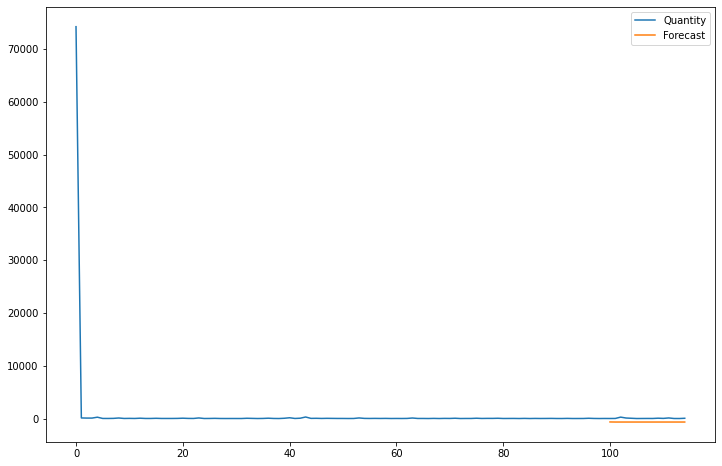

In [48]:
df1_sales['Forecast']=model_fit.predict(start=100,end=150,dynamic=True)
df1_sales[['Quantity','Forecast']].plot(figsize=(12,8))

### 2.2 SARIMA

In [49]:
model=sm.tsa.statespace.SARIMAX(df1_sales['Quantity'],order=(1, 1, 0),seasonal_order=(1,1,0,12))
results=model.fit()

<AxesSubplot:>

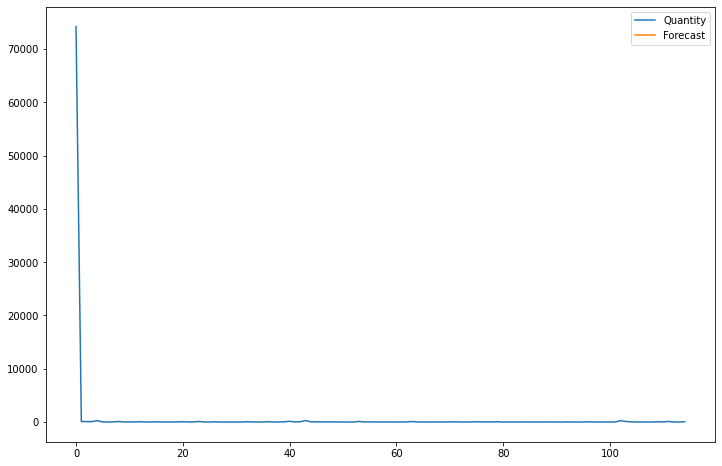

In [50]:
df1_sales['Forecast']=results.predict(start=190,end=250,dynamic=True)
df1_sales[['Quantity','Forecast']].plot(figsize=(12,8))

## ARIMA for Item 1 - Attempt 2

In [248]:
series_date_1 = df1_sales.Quantity
split_time = 80
time_d = np.arange(len(df1_sales))
xtrain_d = series_date_1[:split_time]
xtest_d = series_date_1[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]

In [253]:
arima_model = ARIMA(endog=xtrain_d , order=(1, 0, 0))
arima_model_fit=arima_model.fit()
print(arima_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:               Quantity   No. Observations:                   80
Model:                     ARMA(1, 0)   Log Likelihood                -834.870
Method:                       css-mle   S.D. of innovations           8241.280
Date:                Tue, 16 Mar 2021   AIC                           1675.740
Time:                        08:01:57   BIC                           1682.886
Sample:                             0   HQIC                          1678.605
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1028.6141   1417.423      0.726      0.468   -1749.484    3806.712
ar.L1.Quantity     0.0652      0.982      0.066      0.947      -1.859       1.989
                                    

RMSE Train : 8258.531847218452
RMSE Test : 1000.9046466738083


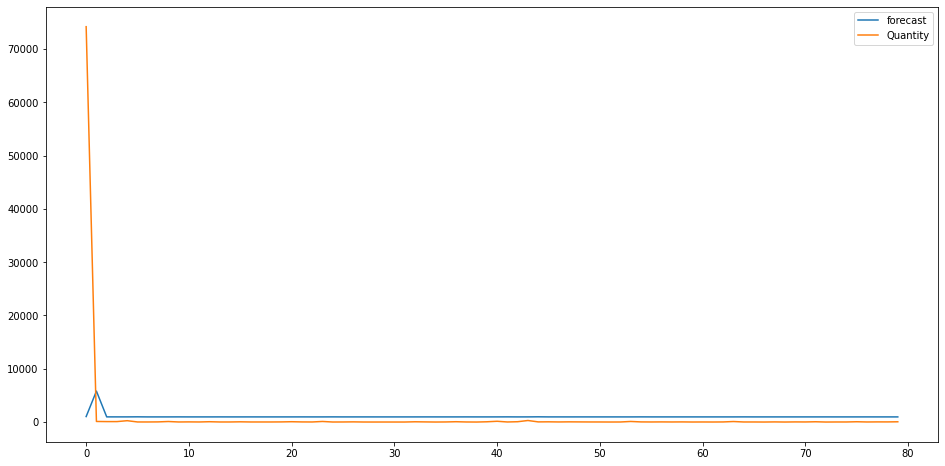

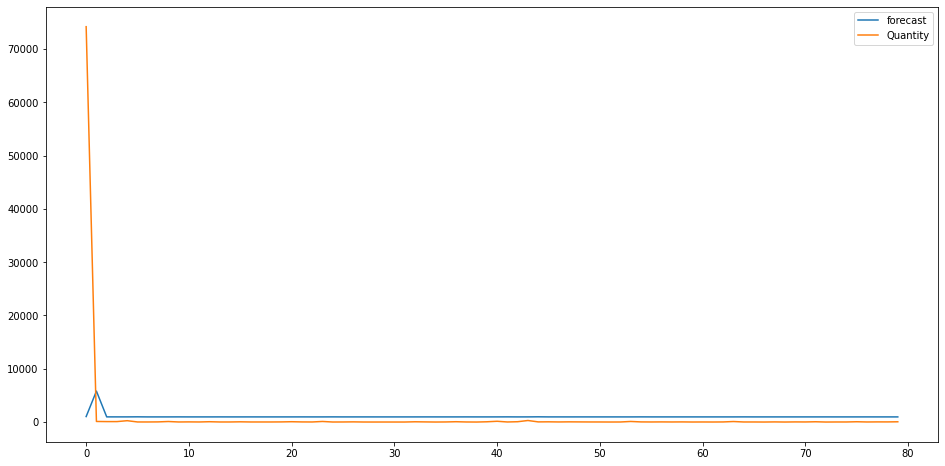

In [254]:
ytrain_pred = arima_model_fit.predict()
ytest_pred = arima_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('RMSE Train :',np.sqrt(np.mean((ytrain_pred - xtrain_d)**2)))
print('RMSE Test :',np.sqrt(np.mean((ytest_pred - xtest_d)**2)))
forecast = arima_model_fit.forecast(20, alpha=0.05)
arima_model_fit.plot_predict()

In [255]:
arima_model_fit.forecast(30)[0]

array([ 964.67483555, 1024.44501407, 1028.34222397, 1028.59633472,
       1028.61290356, 1028.61398391, 1028.61405435, 1028.61405894,
       1028.61405924, 1028.61405926, 1028.61405926, 1028.61405926,
       1028.61405926, 1028.61405926, 1028.61405926, 1028.61405926,
       1028.61405926, 1028.61405926, 1028.61405926, 1028.61405926,
       1028.61405926, 1028.61405926, 1028.61405926, 1028.61405926,
       1028.61405926, 1028.61405926, 1028.61405926, 1028.61405926,
       1028.61405926, 1028.61405926])

In [51]:
df1_sales

,Date,Quantity,Forecast
0,2011-01-18,74215,NaN
1,2011-05-12,108,NaN
2,2011-05-13,84,NaN
3,2011-05-16,84,NaN
4,2011-05-18,252,NaN
...,...,...,...
110,2011-12-01,24,NaN
111,2011-12-05,108,NaN
112,2011-12-06,5,NaN
113,2011-12-07,2,NaN


## Item 2: WORLD WAR 2 GLIDERS ASSTD DESIGNS

In [52]:
df2 = df.loc[df['Description']=='WORLD WAR 2 GLIDERS ASSTD DESIGNS']
df2_sales = df2.groupby(['Date'])['Quantity'].sum().reset_index()

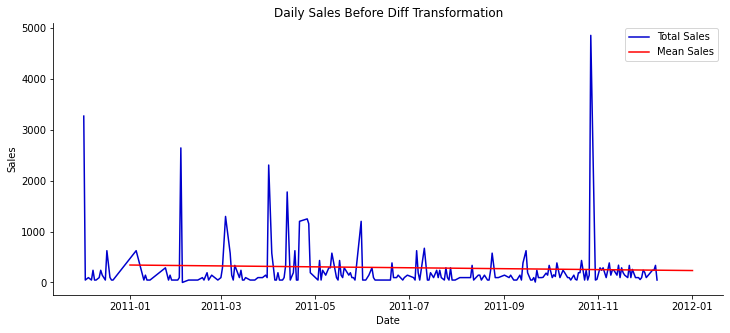

In [53]:
time_plot(df2_sales, 'Date', 'Quantity', 'Daily Sales Before Diff Transformation')

In [54]:
output = adfuller(df2_sales.Quantity)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -16.28 and p-value: 0.00000


In [55]:
d=1
series_date = df2_sales.Quantity.diff(d)
series_date = series_date.dropna()
output = adfuller(series_date)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -7.92 and p-value: 0.00000


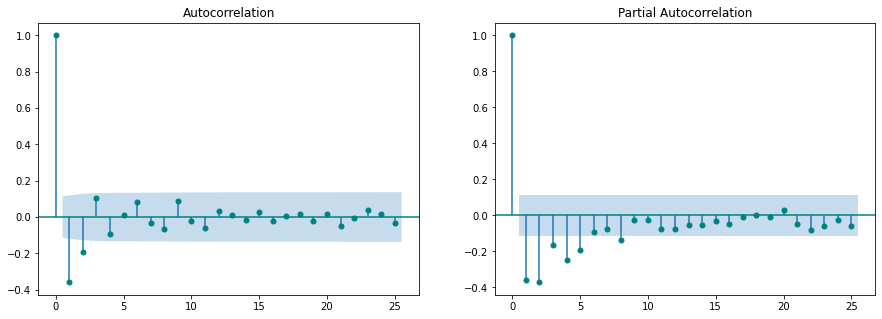

In [175]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(series_date, ax=ax[0], color = 'teal')
plot_pacf(series_date, ax=ax[1], color = 'teal')
plt.show()

### 2.2 SARIMA

In [60]:
model=sm.tsa.statespace.SARIMAX(df2_sales['Quantity'],order=(0, 1, 0),seasonal_order=(0,1,0,12))
results=model.fit()

<AxesSubplot:>

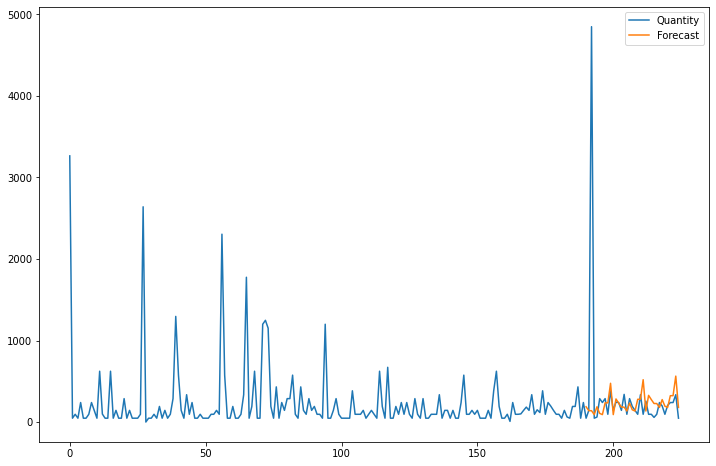

In [61]:
df2_sales['Forecast']=results.predict(start=190,end=250,dynamic=True)
df2_sales[['Quantity','Forecast']].plot(figsize=(12,8))

## ARIMA for Item 2

In [244]:
series_date_2 = df2_sales.Quantity
split_time = 200
time_d = np.arange(len(df2_sales))
xtrain_d = series_date_2[:split_time]
xtest_d = series_date_2[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]

In [245]:
arima_model = ARIMA(endog=xtrain_d , order=(1, 1, 0))
arima_model_fit=arima_model.fit()
print(arima_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Quantity   No. Observations:                  199
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1563.825
Method:                       css-mle   S.D. of innovations            625.711
Date:                Tue, 16 Mar 2021   AIC                           3133.650
Time:                        07:58:34   BIC                           3143.530
Sample:                             1   HQIC                          3137.649
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -9.8951     30.488     -0.325      0.746     -69.651      49.861
ar.L1.D.Quantity    -0.4573      0.067     -6.794      0.000      -0.589      -0.325
                            

RMSE Train : 631.9566993096558
RMSE Test : 216.53486782635323


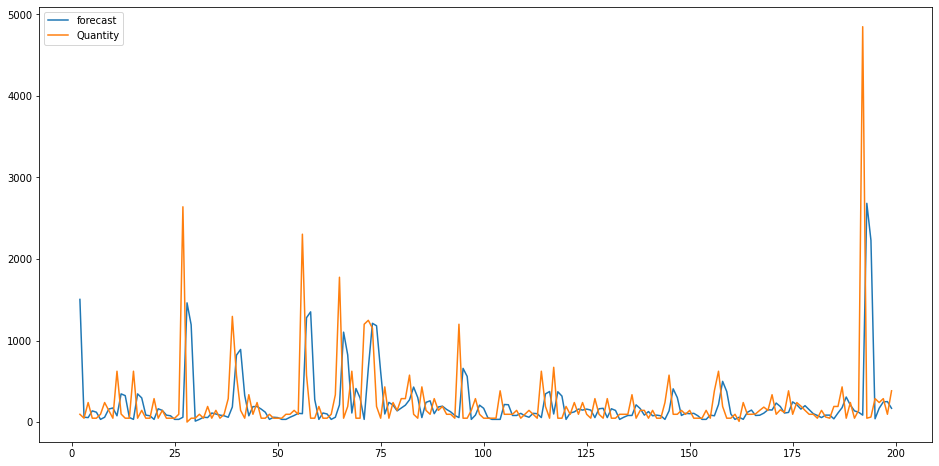

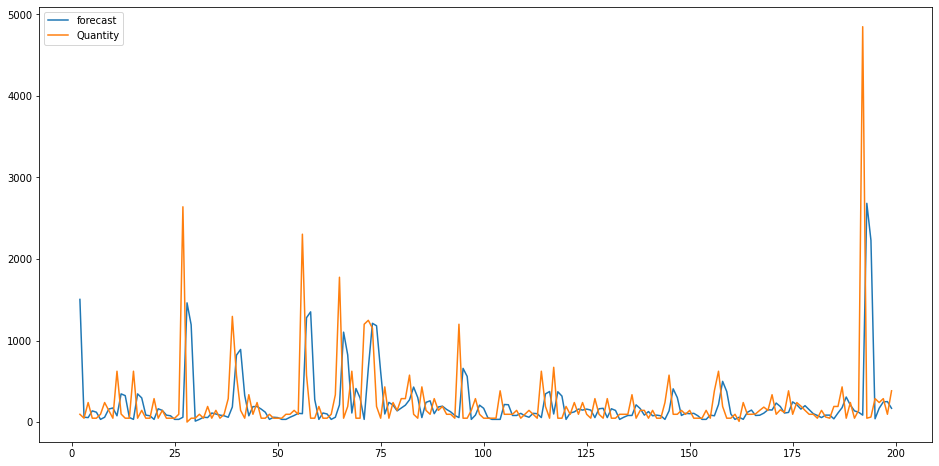

In [246]:
ytrain_pred = arima_model_fit.predict()
ytest_pred = arima_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('RMSE Train :',np.sqrt(np.mean((ytrain_pred - xtrain_d)**2)))
print('RMSE Test :',np.sqrt(np.mean((ytest_pred - xtest_d)**2)))
forecast = arima_model_fit.forecast(20, alpha=0.05)
arima_model_fit.plot_predict()

In [247]:
arima_model_fit.forecast(30)[0]

array([237.87489426, 290.27898279, 251.89394059, 255.0275591 ,
       239.17433223, 232.00395523, 220.86283531, 211.53757073,
       201.38189968, 191.60598075, 181.65639786, 171.78623301,
       161.87974961, 151.98987499, 142.09240503, 132.19840849,
       122.30282352, 112.40796496, 102.5127742 ,  92.61773536,
        82.72262704,  72.8275505 ,  62.93245943,  53.037375  ,
        43.14228753,  33.24720145,  23.35211474,  13.45702832,
         3.56194176,  -6.33314473])

## Item 3: JUMBO BAG RED RETROSPOT

In [189]:
df3 = df.loc[df['Description']=='JUMBO BAG RED RETROSPOT']
df3_sales = df3.groupby(['Date'])['Quantity'].sum().reset_index()

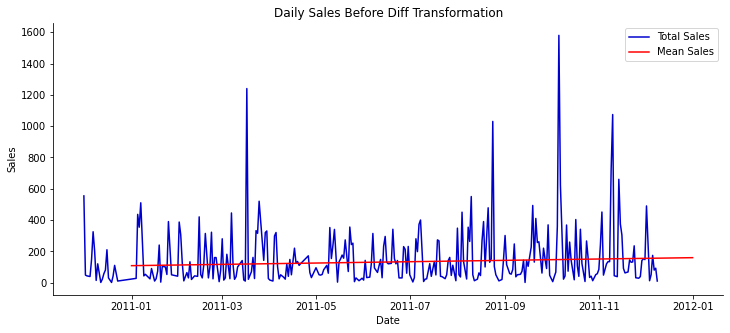

In [81]:
time_plot(df3_sales, 'Date', 'Quantity', 'Daily Sales Before Diff Transformation')

In [82]:
output = adfuller(df3_sales.Quantity)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -12.23 and p-value: 0.00000


In [83]:
d=1
series_date = df3_sales.Quantity.diff(d)
series_date = series_date.dropna()
output = adfuller(series_date)
print('ADF Statistic: {0:.2f} and p-value: {1:.5f}'.format(*output))

ADF Statistic: -10.25 and p-value: 0.00000


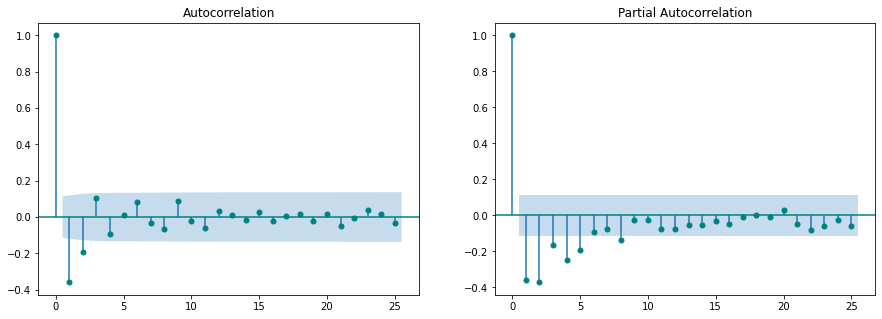

In [84]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(series_date, ax=ax[0], color = 'teal')
plot_pacf(series_date, ax=ax[1], color = 'teal')
plt.show()

In [139]:
resDiff = sm.tsa.arma_order_select_ic(df3_sales['Quantity'], max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (1, 1) is the best.


### 3.1 SARIMA

In [157]:
model=sm.tsa.statespace.SARIMAX(df3_sales['Quantity'],order=(3, 1, 0),seasonal_order=(3,1,0,12))
results=model.fit()

<AxesSubplot:>

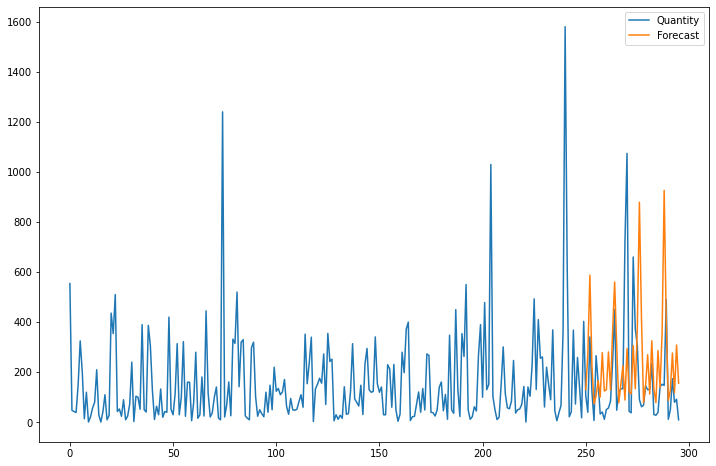

In [158]:
df3_sales['Forecast']=results.predict(start=250,end=350,dynamic=True)
df3_sales[['Quantity','Forecast']].plot(figsize=(12,8))

In [156]:
df3_sales.tail(15)

,Date,Quantity,Forecast,forecast,Quantity_diff
281,2011-11-23,132,151.499876,NaN,2.0
282,2011-11-24,235,219.104015,NaN,103.0
283,2011-11-25,31,167.165887,NaN,-204.0
284,2011-11-27,28,140.003994,NaN,-3.0
285,2011-11-28,39,229.552710,NaN,11.0
286,2011-11-29,141,182.341764,NaN,102.0
287,2011-11-30,152,212.798721,NaN,11.0
288,2011-12-01,147,313.631653,NaN,-5.0
289,2011-12-02,490,214.888324,NaN,343.0
290,2011-12-04,12,159.582115,NaN,-478.0


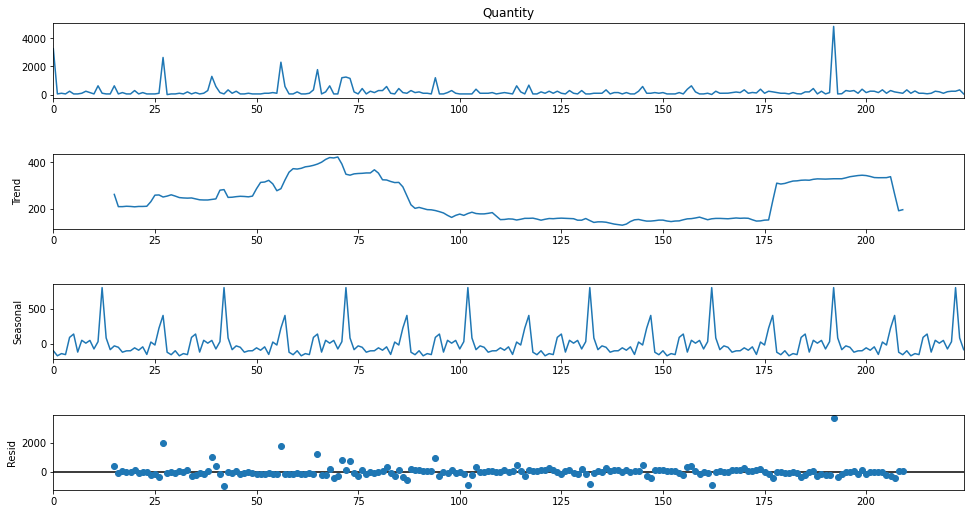

In [104]:
res = sm.tsa.seasonal_decompose(df2_sales.Quantity.dropna(),freq=30)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

## ARIMA for Item 3

In [230]:
series_date_3=df3_sales.Quantity
split_time = 250
time_d=np.arange(len(df3_sales))
xtrain_d=series_date_3[:split_time]
xtest_d=series_date_3[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]

In [237]:
arima_model = ARIMA(endog=xtrain_d , order=(1, 1, 0))
arima_model_fit=arima_model.fit()
print(arima_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Quantity   No. Observations:                  249
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1699.134
Method:                       css-mle   S.D. of innovations            222.418
Date:                Tue, 16 Mar 2021   AIC                           3404.268
Time:                        07:53:29   BIC                           3414.820
Sample:                             1   HQIC                          3408.515
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.4703     10.138     -0.046      0.963     -20.340      19.399
ar.L1.D.Quantity    -0.3920      0.059     -6.635      0.000      -0.508      -0.276
                            

RMSE Train : 264.6740458079438
RMSE Test : 274.73765391516315


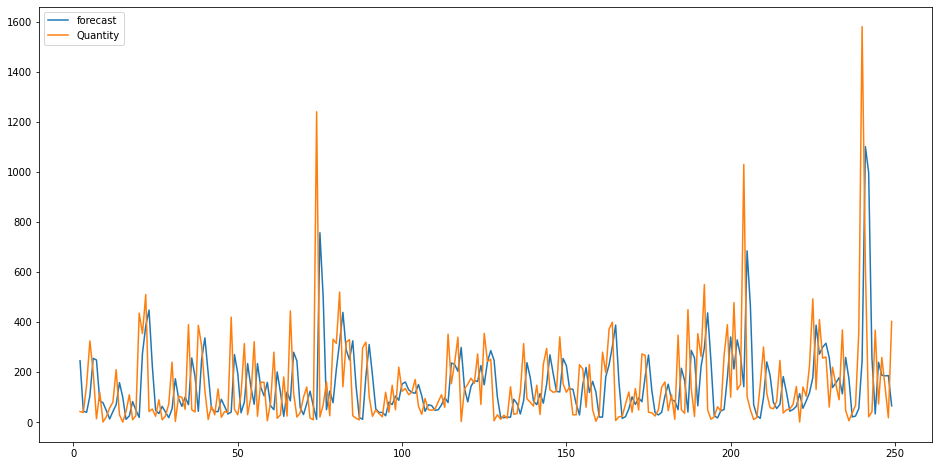

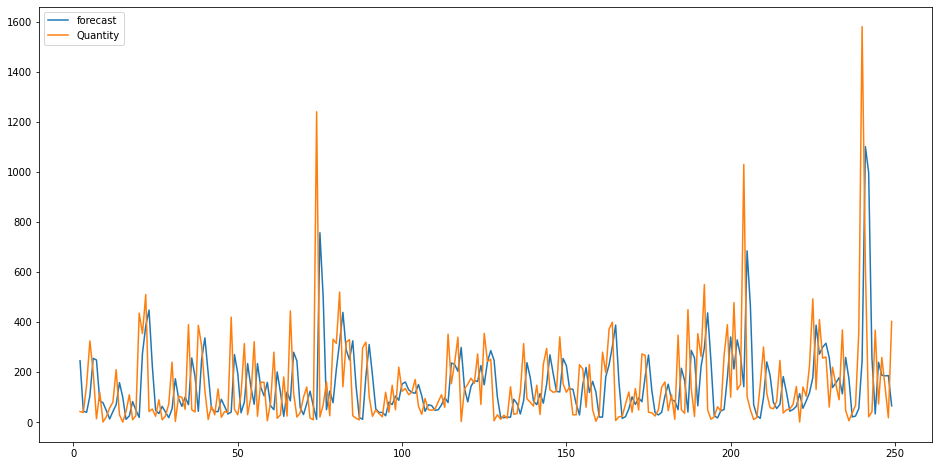

In [239]:
ytrain_pred = arima_model_fit.predict()
ytest_pred = arima_model_fit.predict(start=250,end=350,dynamic=True)

print('RMSE Train :',np.sqrt(np.mean((ytrain_pred - xtrain_d)**2)))
print('RMSE Test :',np.sqrt(np.mean((ytest_pred - xtest_d)**2)))
forecast = arima_model_fit.forecast(20, alpha=0.05)
arima_model_fit.plot_predict()

In [235]:
sarima_model_fit.forecast(30)[0]

array([251.44159291, 310.19153693, 286.5094438 , 295.1372457 ,
       291.10092631, 292.02841036, 291.01029202, 290.75476807,
       290.20033916, 289.76306844, 289.27987663, 288.81468396,
       288.34243638, 287.87295403, 287.40238782, 286.93224644,
       286.46193855, 285.99169592, 285.52142772, 285.05116953,
       284.58090742, 284.11064685, 283.64038568, 283.17012474,
       282.69986371, 282.22960271, 281.7593417 , 281.2890807 ,
       280.8188197 , 280.34855869])

In [227]:
df3_sales['Forecast'] = ytest_pred

In [ ]:
d